In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using device: cuda
Files already downloaded and verified


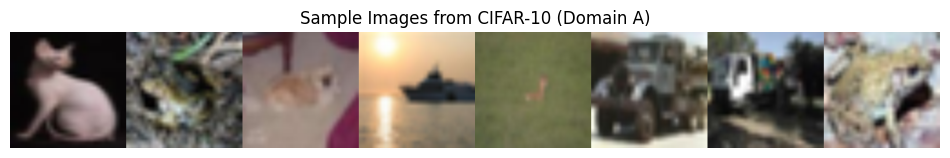

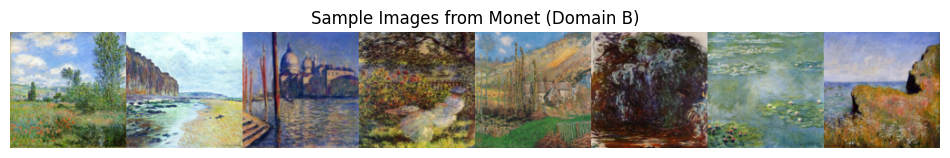

In [ ]:
import os
import random
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets
monet_train_path = "/content/drive/MyDrive/monet/train"
monet_test_path = "/content/drive/MyDrive/monet/test"

# Transformations
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Custom Dataset Loader for Monet
class MonetDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Args:
            folder_path (string): Path to the folder (train or test) with images.
            transform (callable, optional): Transformations to apply to images.
        """
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, 0  # No label required, so returning 0 as placeholder

# Load Monet Dataset
monet_train_dataset = MonetDataset(folder_path=monet_train_path, transform=transform)
monet_test_dataset = MonetDataset(folder_path=monet_test_path, transform=transform)

# CIFAR-10 Dataset
cifar10_dataset = datasets.CIFAR10(root="/content/data", train=True, download=True, transform=transform)

# Randomly sample 1000 images from CIFAR-10
sample_size_cifar10 = 1000
indices = random.sample(range(len(cifar10_dataset)), sample_size_cifar10)
cifar10_subset = Subset(cifar10_dataset, indices)

# Split CIFAR-10 into train and test (80% train, 20% test)
train_size = int(0.8 * len(cifar10_subset))
test_size = len(cifar10_subset) - train_size
cifar10_train, cifar10_test = random_split(cifar10_subset, [train_size, test_size])

# DataLoaders
batch_size = 8
train_loader_A = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_loader_A = DataLoader(cifar10_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

train_loader_B = DataLoader(monet_train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_loader_B = DataLoader(monet_test_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

# Visualization Functions
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Undo normalization
    return tensor.clamp(0, 1)

def show_images(images, title):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.concatenate(images, axis=1))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize CIFAR-10 (Domain A)
batch_A, _ = next(iter(train_loader_A))
show_images(denormalize(batch_A[:8]), title="Sample Images from CIFAR-10 (Domain A)")

# Visualize Monet (Domain B)
batch_B, _ = next(iter(train_loader_B))
show_images(denormalize(batch_B[:8]), title="Sample Images from Monet (Domain B)")


In [ ]:
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=3, num_residuals=6):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downsampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residuals)]
        )
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(64, input_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsampling(x)
        x = self.residual_blocks(x)
        x = self.upsampling(x)
        return self.output_layer(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)



In [ ]:

import torch.optim as optim
import itertools


# Loss functions
adversarial_loss = nn.MSELoss().to(device)
cycle_consistency_loss = nn.L1Loss().to(device)
identity_loss = nn.L1Loss().to(device)

# Initialize models
G_AtoB = Generator().to(device)
G_BtoA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(itertools.chain(G_AtoB.parameters(), G_BtoA.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
epochs = 10
lambda_cycle = 10.0
lambda_identity = 5.0

for epoch in range(epochs):
    for i, (data_A, data_B) in enumerate(zip(train_loader_A, train_loader_B)):
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # Train Generators
        optimizer_G.zero_grad()
        fake_B = G_AtoB(real_A)
        fake_A = G_BtoA(real_B)
        recovered_A = G_BtoA(fake_B)
        recovered_B = G_AtoB(fake_A)

        # Loss
        id_loss = identity_loss(G_BtoA(real_A), real_A) * lambda_identity + \
                  identity_loss(G_AtoB(real_B), real_B) * lambda_identity
        gan_loss = adversarial_loss(D_B(fake_B), torch.ones_like(D_B(fake_B))) + \
                   adversarial_loss(D_A(fake_A), torch.ones_like(D_A(fake_A)))
        cycle_loss = cycle_consistency_loss(recovered_A, real_A) * lambda_cycle + \
                     cycle_consistency_loss(recovered_B, real_B) * lambda_cycle
        loss_G = id_loss + gan_loss + cycle_loss
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators
        optimizer_D_A.zero_grad()
        loss_D_A = adversarial_loss(D_A(real_A), torch.ones_like(D_A(real_A))) + \
                   adversarial_loss(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A.detach())))
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        loss_D_B = adversarial_loss(D_B(real_B), torch.ones_like(D_B(real_B))) + \
                   adversarial_loss(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B.detach())))
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch [{epoch + 1}/{epochs}] - Loss G: {loss_G.item():.4f}, Loss D_A: {loss_D_A.item():.4f}, Loss D_B: {loss_D_B.item():.4f}")


Epoch [1/10] - Loss G: 7.0777, Loss D_A: 0.4642, Loss D_B: 0.4291
Epoch [2/10] - Loss G: 6.8697, Loss D_A: 0.5757, Loss D_B: 0.6476
Epoch [3/10] - Loss G: 6.3276, Loss D_A: 0.4590, Loss D_B: 0.4846
Epoch [4/10] - Loss G: 6.2475, Loss D_A: 0.4560, Loss D_B: 0.4902
Epoch [5/10] - Loss G: 5.3974, Loss D_A: 0.4659, Loss D_B: 0.3622
Epoch [6/10] - Loss G: 6.5368, Loss D_A: 0.4238, Loss D_B: 0.3800
Epoch [7/10] - Loss G: 6.2121, Loss D_A: 0.4104, Loss D_B: 0.3941
Epoch [8/10] - Loss G: 5.0863, Loss D_A: 0.2940, Loss D_B: 0.3996
Epoch [9/10] - Loss G: 5.4920, Loss D_A: 0.2996, Loss D_B: 0.3839
Epoch [10/10] - Loss G: 4.7161, Loss D_A: 0.5569, Loss D_B: 0.5518


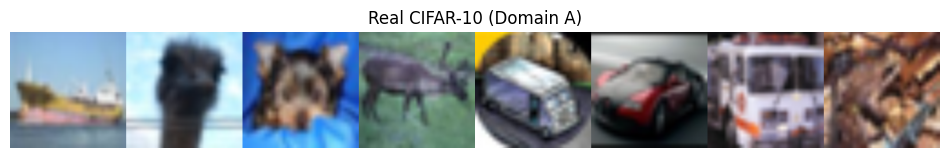

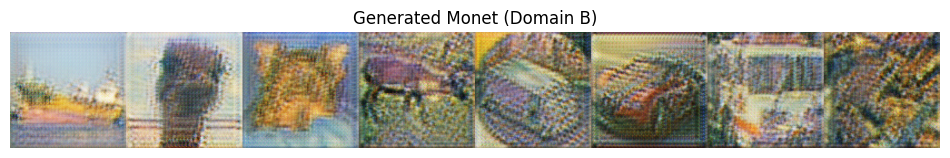

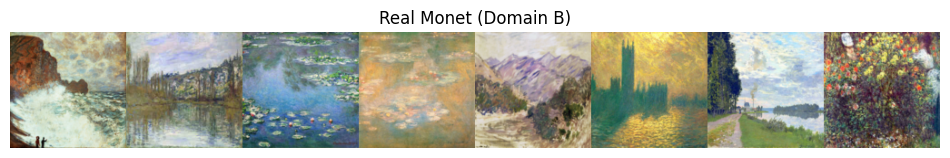

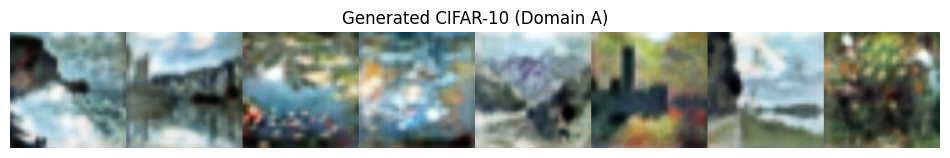

In [ ]:

G_AtoB.eval()
G_BtoA.eval()

# Generate images
with torch.no_grad():
    test_batch_A, _ = next(iter(test_loader_A))
    test_batch_B, _ = next(iter(test_loader_B))

    real_A = test_batch_A.to(device)
    real_B = test_batch_B.to(device)

    fake_B = G_AtoB(real_A)
    fake_A = G_BtoA(real_B)

# Visualize generated images
show_images(denormalize(real_A[:8]), title="Real CIFAR-10 (Domain A)")
show_images(denormalize(fake_B[:8]), title="Generated Monet (Domain B)")
show_images(denormalize(real_B[:8]), title="Real Monet (Domain B)")
show_images(denormalize(fake_A[:8]), title="Generated CIFAR-10 (Domain A)")
